# Notebook 1 — Básico (MLP, seleção de features, foco em Recall)

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

CSV_PATH = None  # ex: 'breast-cancer.csv'
target_col = 'diagnosis'


In [2]:

from sklearn.datasets import load_breast_cancer
if CSV_PATH is None:
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name='target')
else:
    df = pd.read_csv(CSV_PATH)
    y = df[target_col].astype('category').cat.codes
    X = df.drop(columns=[target_col])

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()


In [3]:

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre = ColumnTransformer([('num', num_pipe, num_cols),
                         ('cat', cat_pipe, cat_cols)], remainder='drop')

selector = SelectKBest(score_func=f_classif, k=min(20, (len(num_cols)+len(cat_cols))))

X_proc = pre.fit_transform(X)
X_sel = selector.fit_transform(X_proc, y)

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, stratify=y, random_state=42)


c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


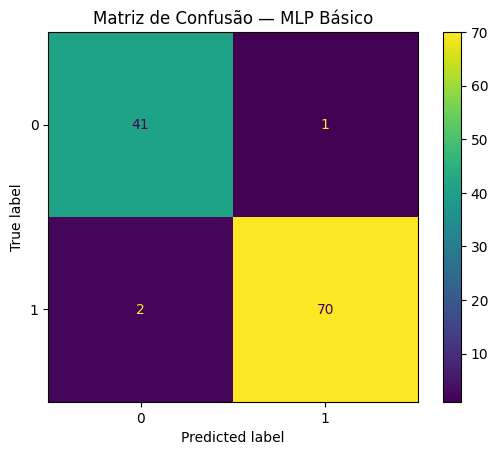

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



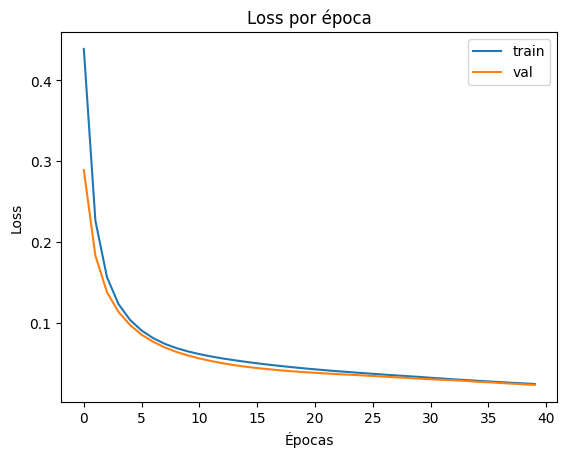

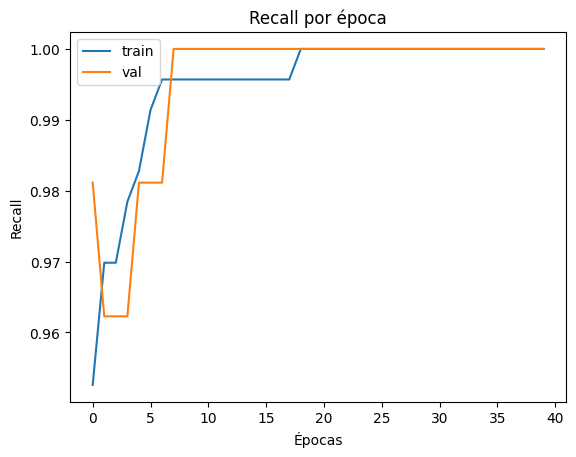

In [4]:

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(name='recall')])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=16, verbose=0)

y_pred = (model.predict(X_test) > 0.5).astype(int)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de Confusão — MLP Básico")
plt.show()

print(classification_report(y_test, y_pred))

plt.plot(history.history.get('loss', []), label='train')
plt.plot(history.history.get('val_loss', []), label='val')
plt.xlabel("Épocas"); plt.ylabel("Loss"); plt.title("Loss por época"); plt.legend(); plt.show()

rk = next((k for k in history.history.keys() if k.lower()=='recall'), None)
vrk = next((k for k in history.history.keys() if k.lower()=='val_recall'), None)
if rk and vrk:
    plt.plot(history.history[rk], label='train')
    plt.plot(history.history[vrk], label='val')
    plt.xlabel("Épocas"); plt.ylabel("Recall"); plt.title("Recall por época"); plt.legend(); plt.show()
